<a href="https://colab.research.google.com/github/tackulus/204426_PROJECT/blob/main/Sprite_download.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pokebase

In [ ]:
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pokebase as pb
from tqdm import tqdm

In [48]:
sprite_rgba = []
for i in tqdm(range(1,802)):
    source = pb.SpriteResource('pokemon', i, official_artwork=True)
    binary = source.img_data
    img = plt.imread(io.BytesIO(binary))
    img = np.asarray(img)
    sprite_rgba.append(img)

sprite_rgba = np.asarray(sprite_rgba)
sprite_rgba.shape # pokedex n == index n-1

100%|██████████| 801/801 [00:00<00:00, 1686.91it/s]


(801, 96, 96, 4)

In [49]:
from skimage.color import rgba2rgb

sprite_rgb = [rgba2rgb(img_rgba) for img_rgba in tqdm(sprite_rgba)]
sprite_rgb = np.asarray(sprite_rgb)
sprite_rgb.shape # pokedex n == index n-1

100%|██████████| 801/801 [00:00<00:00, 4095.43it/s]


(801, 96, 96, 3)

# Feature Extraction by Histogram of Orientation Gradient (HOG)
> https://www.analyticsvidhya.com/blog/2019/09/feature-engineering-images-introduction-hog-feature-descriptor/

In [88]:
from skimage.feature import hog

def feature_extraction_hog(img):
    fd, hog_image = hog(img, orientations=9, pixels_per_cell=(6,6), 
                    cells_per_block=(2, 2), visualize=True, multichannel=True)
    return fd, hog_image

sprite_hog = []
sprite_hog_img = []
for img_rgb in tqdm(sprite_rgb):
    fd, hog_image = feature_extraction_hog(img_rgb)
    sprite_hog.append(fd)
    sprite_hog_img.append(hog_image)

sprite_hog = np.asarray(sprite_hog)
sprite_hog_img = np.asarray(sprite_hog_img)
sprite_hog.shape, sprite_hog_img.shape # pokedex n == index n-1

100%|██████████| 801/801 [00:41<00:00, 19.15it/s]


((801, 8100), (801, 96, 96))

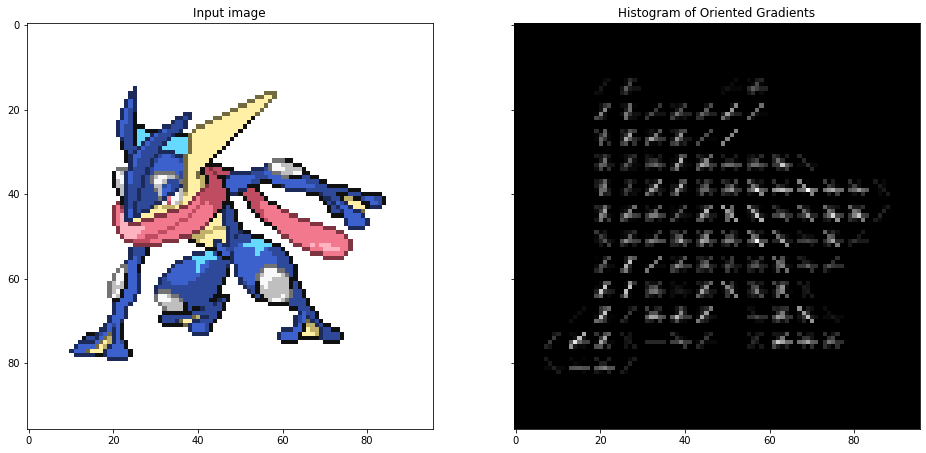

In [149]:
from skimage import exposure

pokedex = 658
img, hog_img = sprite_rgb[pokedex-1], sprite_hog_img[pokedex-1]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), sharex=True, sharey=True) 

ax1.imshow(img, cmap=plt.cm.gray) 
ax1.set_title('Input image') 

# Rescale histogram for better display 
hog_image_rescaled = exposure.rescale_intensity(hog_img, in_range=(0, 10)) 

ax2.imshow(hog_img, cmap=plt.cm.gray) 
ax2.set_title('Histogram of Oriented Gradients')

plt.show()

In [ ]:
import pandas as pd

df = pd.DataFrame(sprite_hog)
df.to_csv('sprite_hog.csv', index=False)

# Feature Extraction by Color Histogram
> https://www.etutorialspoint.com/index.php/310-python-opencv-histograms-of-color-image

In [147]:
import cv2 as cv

def color_histogram(img_rgba, bins=32):
    img = (img_rgba * 255).astype('uint8')
    mask = img[...,3]
    hist1 = cv.calcHist([img],[0],mask,[bins],[0,256])
    hist2 = cv.calcHist([img],[1],mask,[bins],[0,256])
    hist3 = cv.calcHist([img],[2],mask,[bins],[0,256])

    return np.array([hist1, hist2, hist3] / hist1.sum())[...,0]
    
sprite_hist = [color_histogram(img_rgba) for img_rgba in tqdm(sprite_rgba)]
sprite_hist = np.asarray(sprite_hist)

n, ch, bins = sprite_hist.shape 
sprite_hist_flatten = sprite_hist.reshape((n, ch * bins))
sprite_hist.shape, sprite_hist_flatten.shape # pokedex n == index n-1

100%|██████████| 801/801 [00:00<00:00, 8491.16it/s]


((801, 3, 32), (801, 96))

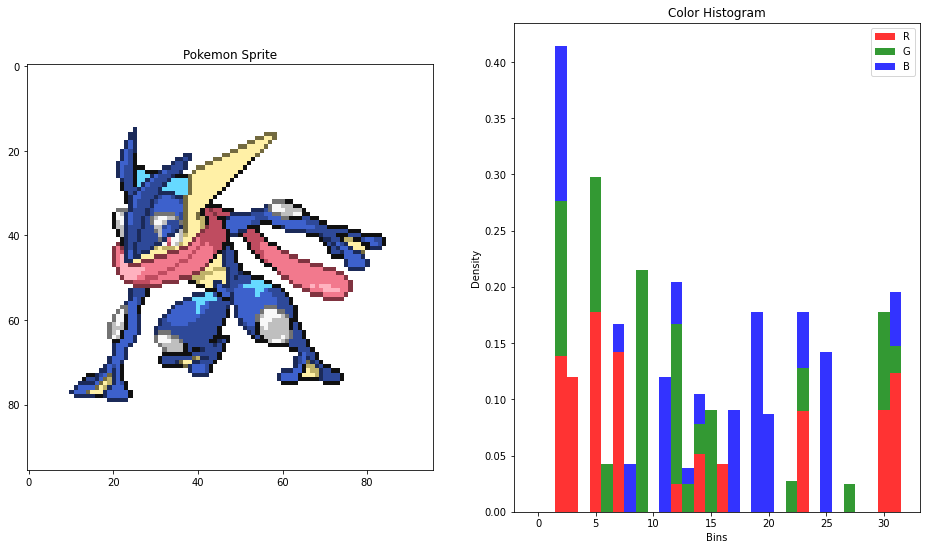

In [145]:
plt.figure(figsize=(16,9))

R, G, B = sprite_hist[657]

plt.subplot(121)
plt.imshow(sprite_rgb[657])
plt.title('Pokemon Sprite')


bins = R.shape[0]
plt.subplot(122)
plt.bar(range(bins), R, color='r',
        width=1, alpha=0.8)
plt.bar(range(bins), G, color='g',
        bottom=R,
        width=1, alpha=0.8)
plt.bar(range(bins), B, color='b',
        bottom=R+G,
        width=1, alpha=0.8)
plt.title('Color Histogram')
plt.legend(['R', 'G', 'B'])
plt.xlabel('Bins')
plt.ylabel('Density')
plt.show()

In [148]:
import pandas as pd

df = pd.DataFrame(sprite_hist_flatten)
df.to_csv('sprite_hist_flatten.csv', index=False)